In [1]:
#Import packages
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import s3fs
import geocat.comp
from datetime import datetime
import dask
import zarr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import netCDF4
import os
import proplot as pplt
import warnings
from numpy import meshgrid, deg2rad, gradient, cos, sin
from xarray import DataArray
from scipy import stats
from sklearn.preprocessing import StandardScaler as scale
warnings.filterwarnings('ignore')

In [52]:
files='/home/jupyter-dipti/work/ISMR_CITCZ/Data/Regrided_ERA5.nc'
#Open ERA5 Dataset
data=xr.open_dataset(files)
cres=data.cres
cresSurf=data.cresSurf
netTOA=data.netTOA
crel=data.crel
crelSurf=data.crelSurf
pr=data.pr

lat=cres.lat
lon=cres.lon


#For precipitation do June-September, then test lead lag cre variables also using 4 months. Go up to February in the lag
#Try 4 months for CRE and try one month as well, see which regression is the best


#Select July Month Indexes
months=[6,7,8,9]
#varOut.where(varOut.time.dt.month.isin(months), drop=True) #Change varOut to desired variable

cres=cres.where(cres.time.dt.month.isin(months), drop=True)

month_idxs=cres.groupby('time.month').groups
april_idxs=month_idxs[4]
july_idxs=month_idxs[7]
cres=cres.isel(time=april_idxs)
cresSurf=cresSurf.isel(time=july_idxs)
netTOA=netTOA.isel(time=july_idxs)
crel=crel.isel(time=april_idxs)
crelSurf=crelSurf.isel(time=july_idxs)
prec=pr.isel(time=july_idxs)

time=cres.time

In [ ]:
def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)

def remove_time_mean(x):
        return x - x.mean(dim='time')

def removeSC(x):
        return x.groupby('time.month').apply(remove_time_mean)
    
def calStdNorAnom(x):
    for m in np.unique(x.time.dt.month):
        mData=x[x.time.dt.month==m]
        mRolling=mData.mean()
        sRolling=mData.std()
        normData=(mData-mRolling)/sRolling
    return normData

In [54]:
cres=detrend(cres,time)

AttributeError: 'DataArray' object has no attribute 'reshape'

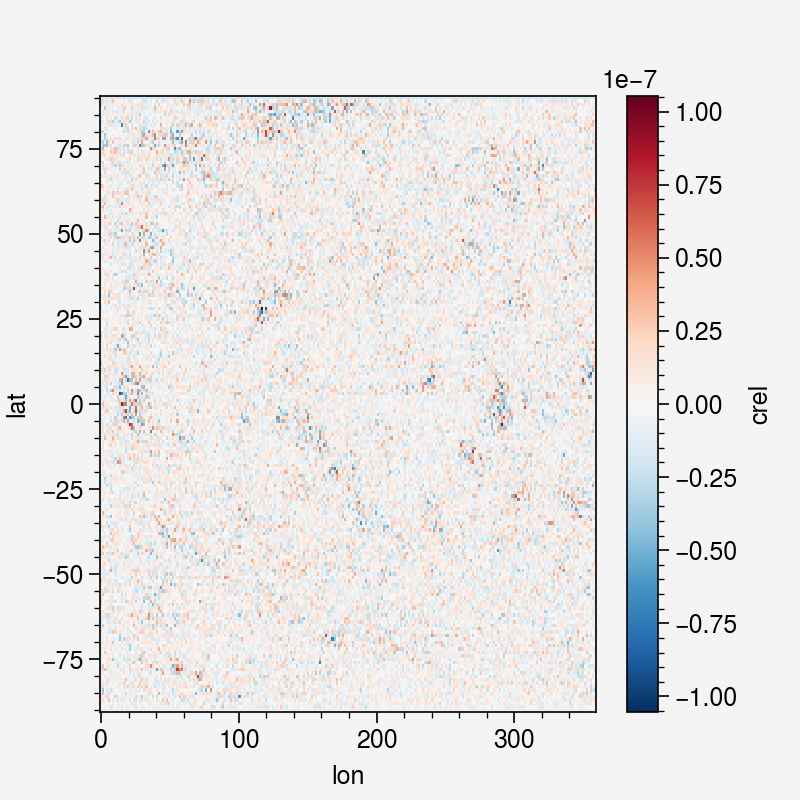

In [51]:
t1=crel.stack(z=("lat", "lon"))
#fit scaler on training data
norm = scale().fit(t1)
# transform training data
t1.values = norm.transform(t1)
crel.values=t1.unstack()

#crel=crel.shift(time=3)
test=crel.mean(axis=0)
test.plot()

In [43]:
def normalize(t,window:int = 31,proc:int = 40):
        '''
        Calculate anomaly and normalize (repeat boundary values) for monthly data
        averages across years (12 time step skips)
        x (np.ndarray) - integer values
        t (integer) - time
        window (integer) - years in the averaging window must be odd for now
        '''
        assert window%2 == 1
        tmax = x.shape[0]
        halfwindow = window//2
        yr = t//12
        mon = t%12
        selx = np.zeros_like(x[:window])
        # get rolling window (backfills/forward fills with first/last value)
        if t-halfwindow*12 < 0:
            selx[:halfwindow - yr] = x[mon]
            selx[halfwindow-yr:] = x[mon:t+halfwindow*12+1:12]
        elif t+halfwindow*12+1 > tmax:
            selx[halfwindow + (tmax//12 - yr):] = x[tmax- 12 + mon]
            selx[:halfwindow + (tmax//12 - yr)] = x[t - halfwindow*12::12]
        else:
            selx = x[t-halfwindow*12:t+halfwindow*12+1:12]
        # calculate normalized
        normed = (x[t] - np.mean(selx,axis=0))/np.std(selx,axis=0)
        return normed
        ### run normalization
        print('Normalize')
        ntime = x.shape[0]

        # parallelize normalizing across time (trivially parallel)
        with Pool(processes=proc) as pool: 
            outdata = pool.map(normalize, range(ntime))
        t4 = time.time()
        print('Time : ',t4-t3)
        return np.array(outdata,dtype=np.float32)

test=normalize(cres)

NameError: name 'x' is not defined